In [17]:
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline
import time
from torch.autograd import Variable
import pandas as pd
import cv2
import torch
import numpy as np
from facenet_pytorch import MTCNN
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
from torch.nn import functional as F


In [18]:
train_transforms = tt.Compose([tt.Grayscale(num_output_channels=1),
                               tt.Resize((128,128)),  # Картинки чернобелые
                         
                         # Настройки для расширения датасета
#                                tt.AutoAugment(fill=0),
                         tt.RandomHorizontalFlip(),           # Случайные повороты на 90 градусов
                         tt.RandomRotation(30),               # Случайные повороты на 30 градусов
# #                          tt.Normalize((0.5), (0.5), inplace=True),
                         tt.RandomCrop(128, padding=4, padding_mode='reflect'),
                         tt.RandomRotation(60),
                         tt.ToTensor()])                      # Приведение к тензору

test_transforms = tt.Compose([tt.Grayscale(num_output_channels=1),tt.Resize((128,128)), tt.ToTensor()])

In [19]:
data_dir = 'leapGestRecog'
print(os.listdir(data_dir))

['test', 'train']


In [20]:
train_dataset = ImageFolder(data_dir + '/train', train_transforms)
test_dataset  = ImageFolder(data_dir + '/test', test_transforms)

In [21]:
classes_train = train_dataset.class_to_idx
classes_test = test_dataset.class_to_idx
classes_train, classes_test

({'03_fist': 0, '07_ok': 1}, {'03_fist': 0, '07_ok': 1})

In [22]:
digit_to_classname = {0:'03_fist', 1:'07_ok'}

In [23]:
batch_size = 2

In [24]:
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size)

In [25]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(images[0].shape, labels)
        
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break
    

torch.Size([1, 128, 128]) tensor([1, 0])


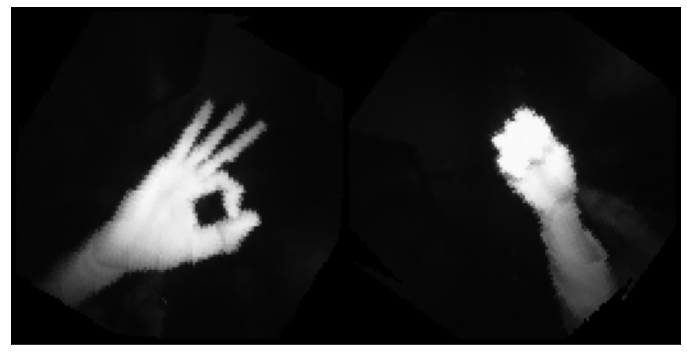

In [27]:
show_batch(train_dataloader)

In [28]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [29]:
device = get_default_device()
device

device(type='cuda')

In [30]:
train_dataloader = DeviceDataLoader(train_dataloader, device)
test_dataloader = DeviceDataLoader(test_dataloader, device)

In [31]:
#  Создадим модель для классификации жестов

class FERModel(nn.Module):
    def __init__(self, in_chnls, num_cls):
        super().__init__()
        
        self.conv1 = self.conv_block(in_chnls, 64, pool=True)           # 64x24x24 
        self.conv2 = self.conv_block(64, 128, pool=True)                # 128x12x12
        self.resnet1 = nn.Sequential(self.conv_block(128, 128), self.conv_block(128, 128))    # Resnet layer 1: includes 2 conv2d
        
        self.conv3 = self.conv_block(128, 256, pool=True)       # 256x6x6 
        self.conv4 = self.conv_block(256, 512, pool=True)       # 512x3x3
        self.resnet2 = nn.Sequential(self.conv_block(512, 512), self.conv_block(512, 512))    # Resnet layer 2: includes 2 conv2d
        
        self.classifier = nn.Sequential(nn.MaxPool2d(3),
                                        nn.Flatten(),
                                        nn.Linear(2048, num_cls),
                                        nn.Softmax()
                                           )    # num_cls
        
    @staticmethod
    def conv_block(in_chnl, out_chnl, pool=False, padding=1):
        layers = [
            nn.Conv2d(in_chnl, out_chnl, kernel_size=3, padding=padding),
            nn.BatchNorm2d(out_chnl),
            nn.ReLU(inplace=True)]
        if pool: layers.append(nn.MaxPool2d(2))
        return nn.Sequential(*layers)
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.resnet1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.resnet2(out) + out
        return self.classifier(out)

In [32]:
# Обучать будем на два класса : "окей" и "кулак"

In [33]:
ferModel = FERModel(1,2).to(device)

In [34]:
# ferModel.load_state_dict(torch.load('models/ferModel'))

<All keys matched successfully>

In [35]:
if torch.cuda.is_available(): 
    torch.cuda.empty_cache()

In [36]:
#  Определим гиперпараметры

epochs = 100
max_lr = 0.0001
grad_clip = 0.1
weight_decay = 1e-4
optimizer = torch.optim.Adam(ferModel.parameters(), max_lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_dataloader))

In [112]:
epoch_losses = []
true_y = []
pred_y = []



for epoch in range(epochs):
    
    time1 = time.time()
    running_loss = 0.0
    epoch_loss = []
    ferModel.train()
    
    for batch_idx, (data, labels) in enumerate(train_dataloader):
        data, labels = data.cuda(), labels.cuda()       
        
        optimizer.zero_grad()
        
        outputs = ferModel(data)

        _, preds = torch.max(outputs, 1)
        
        true_y.append(labels.to('cpu'))
        pred_y.append(outputs.to('cpu'))
        
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
#         scheduler.step()
        
        
        running_loss += loss.item()
        epoch_loss.append(
            
            
            
            loss.item())
        if (batch_idx+1) % 10000 == 9999:
            print(f'Train Epoch: {epoch+1}, Loss: {running_loss/10000}')
            time2 = time.time()
            print(f'Spend time for 10000 images: {time2 - time1} sec')
            time1 = time.time()
            running_loss = 0.0
    print(f'Epoch {epoch+1}, loss: ', np.mean(epoch_loss))
    epoch_losses.append(epoch_loss)
    

Epoch 1, loss:  0.3132705411527838
Epoch 2, loss:  0.31326474592089654
Epoch 3, loss:  0.3132617599623544
Epoch 4, loss:  0.31326176907335007
Epoch 5, loss:  0.3132617263070175
Epoch 6, loss:  0.31326773496610777
Epoch 7, loss:  0.3132617768219539
Epoch 8, loss:  0.31326172083616255
Epoch 9, loss:  0.3132618843019009
Epoch 10, loss:  0.31326170182653834
Epoch 11, loss:  0.31326168400900706
Epoch 12, loss:  0.31326167253511294
Epoch 13, loss:  0.3132642933087689
Epoch 14, loss:  0.3132616724286761
Epoch 15, loss:  0.31326166604246414
Epoch 16, loss:  0.3132616659360273
Epoch 17, loss:  0.3132616927794048
Epoch 18, loss:  0.313261664722647
Epoch 19, loss:  0.31326166080577034
Epoch 20, loss:  0.31326165989041327
Epoch 21, loss:  0.31337971559592653
Epoch 22, loss:  0.3132660734653473
Epoch 23, loss:  0.3132620194554329
Epoch 24, loss:  0.3132618509232998
Epoch 25, loss:  0.3132623548167092
Epoch 26, loss:  0.3132618384063244
Epoch 27, loss:  0.31326169375862395
Epoch 28, loss:  0.3132633

In [ ]:
# Сохраним модель
# torch.save(ferModel.state_dict(), 'models/ferModel')

torch.Size([2, 1, 128, 128])


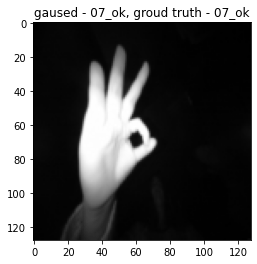

torch.Size([2, 1, 128, 128])


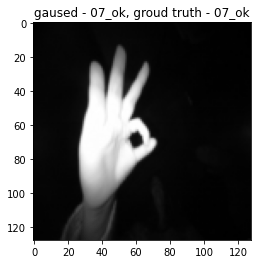

torch.Size([2, 1, 128, 128])


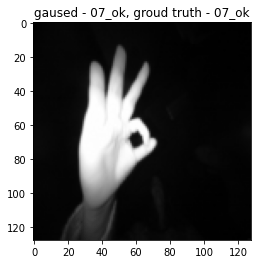

torch.Size([2, 1, 128, 128])


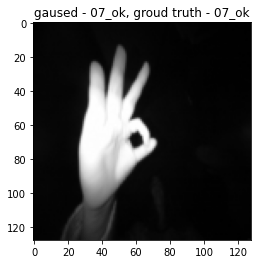

torch.Size([2, 1, 128, 128])


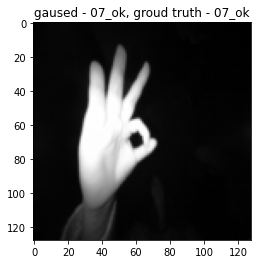

torch.Size([2, 1, 128, 128])


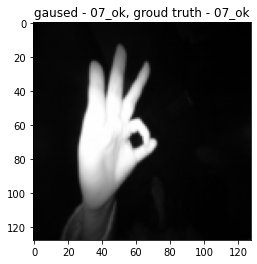

torch.Size([2, 1, 128, 128])


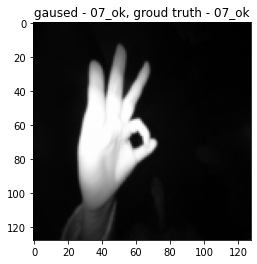

torch.Size([2, 1, 128, 128])


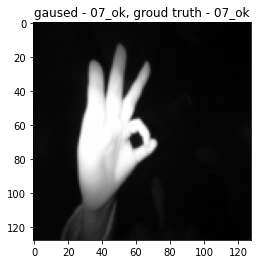

torch.Size([2, 1, 128, 128])


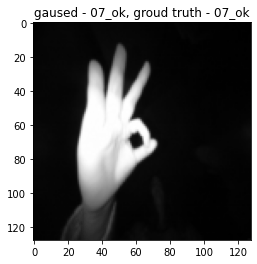

torch.Size([2, 1, 128, 128])


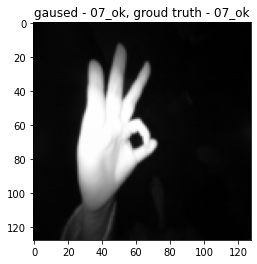

torch.Size([2, 1, 128, 128])


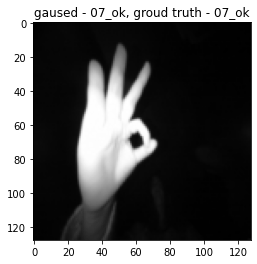

In [353]:
with torch.no_grad():
    for i, data in enumerate(test_dataloader):
        if i>350:
            images, labels = data
#             print(images.shape)
            images, labels = images, labels
            images, labels=images.cuda(), labels.cuda()
    
            outputs = ferModel(images)
#             outputs = model(images)
            print(images.shape)
    #         print(outputs[10].shape)
            plt.title(f'gaused - {digit_to_classname[outputs[0].argmax().item()]}, groud truth - {digit_to_classname[labels[0].data.item()]}')
            plt.imshow(images[0].cpu().squeeze(), cmap='gray')
            plt.show()
            if i>360:
                break

In [326]:
# Создадим класс для распознования жестов
# Сначала, в цикле ищем лицо
# Как только лицо найдено, запускаем второй цикл,
# в котором выделяем кисть руки и классифицируем ее
#  В зависимости от результатов классификации,
# выводится тот или иной текст.

In [37]:
import mediapipe as mp
mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands


In [54]:
class Define_gestures():
    
#  инициализируем модель 

    def __init__(self,model):
            
            self.model = model
            
            self.make_gestures()
            
#  ищем лицо
            
    def make_gestures(self):
        
        mtcnn = MTCNN()
        
    
        while cap.isOpened():
            
            try:

                success, image = cap.read()

                if not success:
                    continue

                boxes, probs, landmarks = mtcnn.detect(image, landmarks=True)


                if probs :

                    self.get_gestures()         

                if cv2.waitKey(5) & 0xFF == 27:        
                    cv2.destroyAllWindows()
                    
            except Exception as e:
                print('Something wrong!')
                print(f'error : {e}')
                
        return cap.release()
            
#      ищем кисть и совершаем действие 

    def get_gestures(self):

        i=0

        with mp_hands.Hands(
        static_image_mode=False,
        max_num_hands=1,
        min_tracking_confidence=0.8,
        min_detection_confidence=0.8) as hands:

            while cap.isOpened():

                success, image = cap.read()
                i+=1

                if not success:

                    continue

                results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                

                if (results.multi_handedness != None) & (i // 5 != 0):
                    

                    predict=self.def_gesture(image,results)

                    

                    if predict==0:

                        cv2.putText(image,'ALL RIGHT', (int(200), int(300)), 
                                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)

                    elif predict==1:
                        
                        cv2.putText(image,'You are ok', (int(200), int(300)), 
                                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)

                cv2.imshow("gestures", image)
                if cv2.waitKey(5) & 0xFF == 27:
                    cv2.destroyAllWindows()
                    return cap.release()
                
# локализуем кисть и классифицируем ее                
                
    def def_gesture(self,image,results):
        
        
        image_height, image_width, _ = image.shape

        x_max=0
        y_max=0
        x_min=10000
        y_min=10000

        for i in range(len(results.multi_hand_landmarks[0].landmark)):
            
            x_max=max(results.multi_hand_landmarks[0].landmark[i].x,x_max)
            y_max=max(results.multi_hand_landmarks[0].landmark[i].y,y_max)
            x_min=min(results.multi_hand_landmarks[0].landmark[i].x,x_min)
            y_min=min(results.multi_hand_landmarks[0].landmark[i].y,y_min)

            x_max=int(x_max*image_width)
            y_max=int(y_max*image_height)
            x_min=int(x_min*image_width)
            y_min=int(y_min*image_height)

            x_max=max(x_max,0)
            y_max=max(y_max,0)
            x_min=max(x_min,0)
            y_min=max(y_min,0)

            x_max=min(x_max,image_width)
            y_max=min(y_max,image_height)
            x_min=min(x_min,image_width)
            y_min=min(y_min,image_height)



        image0=image[y_min:y_max,x_min:x_max]
        gray_image = cv2.cvtColor(image0, cv2.COLOR_BGR2GRAY)
        img=cv2.resize(gray_image, (128,128))
        img=np.array(img).reshape(1,1,128,128)
        img = torch.as_tensor(img).float().cuda()
        outputs = self.model(img)
        predict=outputs[0].argmax().item()

        return predict





In [55]:
cap=cv2.VideoCapture(0)
Define_gestures(ferModel)